# bottom-up continuous likelihoods

## flow fields

In [2]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

model loaded!


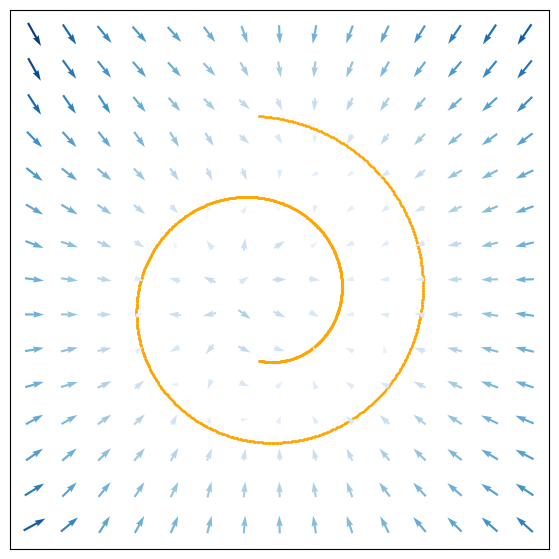

In [3]:
# display the flow field for the prior sampler 

from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 1e3
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

# ----------------- calculate flow field for diffusion model ----------------- #
from utils import select_model
# prior_sampler = select_model('unconditional-dendritic', 47)[0]
prior_sampler = select_model('unconditional-dendritic-4-layers', 1)[0]

lim=1.5
num_vectors_per_dim=15
from likelihood_utils import calculate_prior_score_flow_field
score_xs, score_ys, color = calculate_prior_score_flow_field(prior_sampler, lim, num_vectors_per_dim, t=30)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=1, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
        #   scale=12,  # 47
          scale=12,
          clim=(0, 4))
ax.set_aspect('equal')
from utils import remove_all_ticks_and_labels
_=remove_all_ticks_and_labels(ax)

from plot import save_fig
# save_fig(fig, 'figure2-prior')

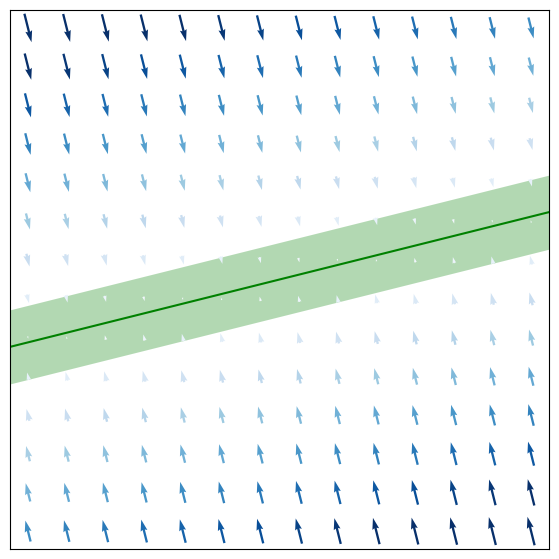

In [4]:
# display the flow field for the continuous likelihood

# ------------------------- likelihood model details ------------------------- #
v = np.array([[4, 1]]).T  # constraint vector
M = v / np.linalg.norm(v)
Mm = M @ M.T  # projection matrix
Mm = torch.from_numpy(Mm).float()
constraint_sigma = 0.1

# --------------- calculate flow field for the likelihood model -------------- #
from likelihood_utils import compute_occlusion_score_flow_field
lims=[-lim, lim]
x_hyps, scores, color = compute_occlusion_score_flow_field(Mm, constraint_sigma, t=1)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.set(xlim=lims, ylim=lims)
# show the linear constraint along with its standard deviation
from plot import draw_constraint_line
draw_constraint_line(ax, v, constraint_sigma, lim)  # show 2 stdevs
ax.quiver(*x_hyps.T, *scores.T,
            color,
            cmap="Blues",
            angles = 'xy',
            scale_units = 'width',
            scale = 400,
            pivot = 'mid',
            clim=(-.05, 400)
            )
ax.set_aspect('equal')
_ = remove_all_ticks_and_labels(ax)

from plot import save_fig
# save_fig(fig, 'figure2-llh')

## comparison of reverse processes
samples generated by iid diffusion reverse process, compared against those generated by sequential neural reverse process

cpu


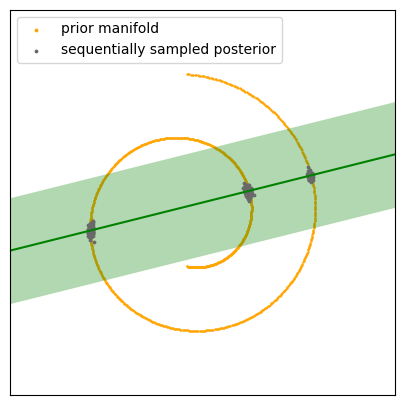

In [5]:
device = 'cpu'
print(device)

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
# likelihood_sigma = 0.1
# s = 0.1

# likelihood_sigma = 0.27
likelihood_sigma = 0.4
s = 1
num_cycles = 500

# initialize a random point on the ground truth manifold and start the sequential posterior sampling
num_samples_in_gt_manifold = 1000
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)[1]

'''generate new samples'''
# from likelihood_utils import sequential_posterior_sampler
# prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic-4-layers', 1)  # 47
# manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
# samples_seq, samples_seq_reverse = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles, num_steps, normalized_beta_schedule=False)

'''load previously generated samples'''
import zarr
data_dir_llh = os.path.join(base_dir, 'core', 'saved_arrays', 'likelihood')
samples_seq_reverse = zarr.load(os.path.join(data_dir_llh, 'samples_seq_reverse_process.zarr'))
samples_seq_reverse = samples_seq_reverse[:500]
samples_seq = samples_seq_reverse[:, -1]

# plot the results of the sequential posterior sampling
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set(xlim=lims, ylim=lims)
ax.scatter(*dataset[500].T, s=3, alpha=1, c='orange', label='prior manifold')
ax.scatter(*dataset.T, s=0.5, alpha=1, c='orange')
draw_constraint_line(ax, v, likelihood_sigma, lim, num_sd=1)

ax.scatter(*samples_seq.T, s=3, c='dimgrey', label='sequentially sampled posterior')
ax.set_aspect('equal')
ax.legend(loc="upper left")
a = remove_all_ticks_and_labels(ax)

model loaded!


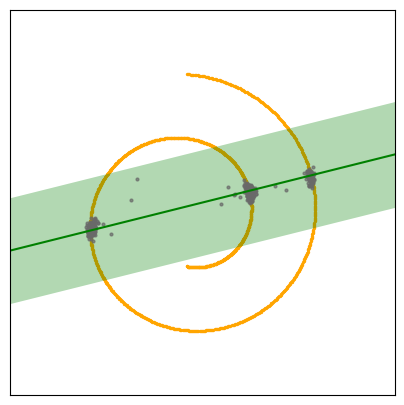

In [30]:
# generate iid samples from a standard diffusion model, starting from samples from a normal distribution with identity covariance
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)  # 47

from likelihood_utils import posterior_sample_loop_occlusion
sample_size = 500
samples_iid_reverse = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, normalized_beta_schedule=True)
# plot the results of the sequential posterior sampling
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set(xlim=lims, ylim=lims)
ax.scatter(*dataset.T, s=2, alpha=1, c='orange')
draw_constraint_line(ax, v, likelihood_sigma, lim, num_sd=1)

ax.scatter(*samples_iid_reverse[-1].T, s=4, alpha=0.7, c='dimgrey')
ax.set_aspect('equal')
a = remove_all_ticks_and_labels(ax)

Text(0.5, 0.98, 'sequential sampling from the posterior distribution')

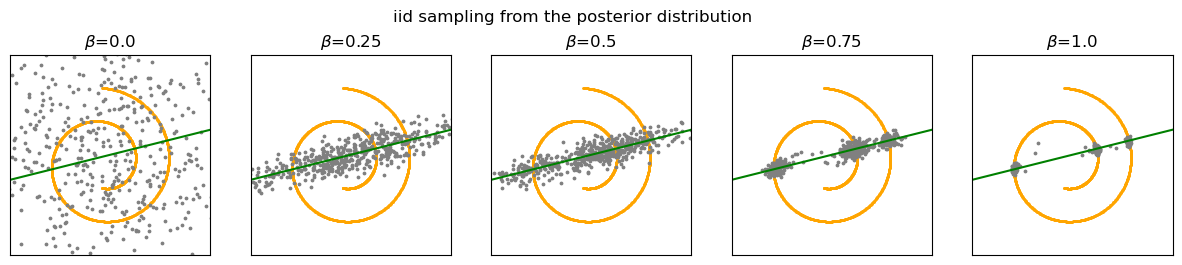

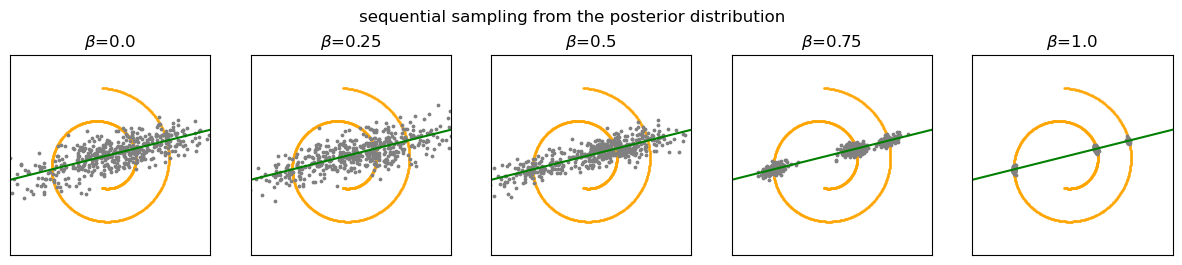

In [35]:
# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate([0, 25, 50, 75, 100]):
    ax[i].scatter(*dataset.T, s=1, c='orange')
    ax[i].scatter(*samples_iid_reverse[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[i], v, constraint_sigma, lim, show_stdev=False)
    ax[i].set(title=f'$\\beta$={int(temp)/100}')
    ax[i].set_aspect('equal')
    ax[i].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
fig.suptitle('iid sampling from the posterior distribution')


# plot the reverse process of the sequentially generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for idx, temp in enumerate([0, 25, 50, 75, 100]):
    ax[idx].scatter(*dataset.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*samples_seq_reverse[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[idx], v, constraint_sigma, lim, show_stdev=False)
    ax[idx].set(title=f'$\\beta$={int(temp)/100}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
fig.suptitle('sequential sampling from the posterior distribution')

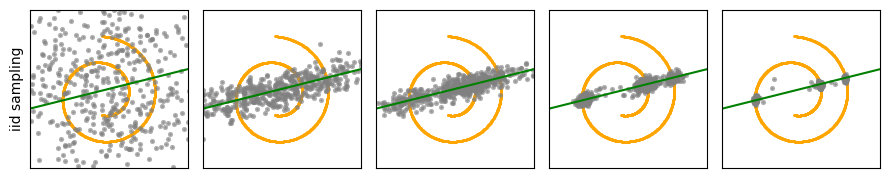

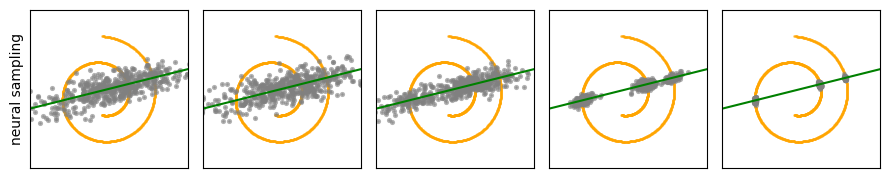

In [36]:
fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate([0, 1, 50, 75, 100]):
    ax[i].scatter(*dataset.T, s=1, c='orange')
    ax[i].scatter(*samples_iid_reverse[int(temp)].T, s=3, alpha=0.6, lw=2, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[i], v, constraint_sigma, lim, show_stdev=False)
    ax[i].set_aspect('equal')
    ax[i].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
ax[0].set(ylabel='iid sampling')
fig.tight_layout()
save_fig(fig, 'figure2-iid-sampling')

# plot the reverse process of the sequentially generated posterior samples at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True)
for idx, temp in enumerate([0, 1, 50, 75, 100]):
    ax[idx].scatter(*dataset.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*samples_seq_reverse[:, int(temp)].T, s=3, alpha=0.6, lw=2, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[idx], v, constraint_sigma, lim, show_stdev=False)
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
ax[0].set(ylabel='neural sampling')
fig.tight_layout()
# save_fig(fig, 'figure2-neural-sampling')

## Fig 2E

Evaluation at $\mathbf{x}_{t}$ vs $\mu_{\theta}(\mathbf{x}_{t-1})$

In [6]:
data_dir = os.path.join(base_dir, 'core/saved_arrays/samples/', f'unconditional-dendritic-4-layers_1')
data_dir_iid_xt = os.path.join(data_dir, 'posterior-iid-unimodal-bu-xt', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_iid_mu = os.path.join(data_dir, 'posterior-iid-unimodal-bu-mu', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_seq_xt = os.path.join(data_dir, 'posterior-seq-unimodal-bu-xt', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')
data_dir_seq_mu = os.path.join(data_dir, 'posterior-seq-unimodal-bu-mu', 'num_samples=1e+04-num_runs=1e+01-batch_idx=0')

num_runs = 10
samples_iid_reverse_xt = []
samples_iid_reverse_mu = []
samples_seq_reverse_xt = []
samples_seq_reverse_mu = []
for run_idx in range(num_runs):
    samples_iid_xt = zarr.load(os.path.join(data_dir_iid_xt, f'x_rev-run_num={run_idx}.zarr'))
    samples_iid_mu = zarr.load(os.path.join(data_dir_iid_mu, f'x_rev-run_num={run_idx}.zarr'))
    samples_iid_reverse_xt.append(samples_iid_xt)
    samples_iid_reverse_mu.append(samples_iid_mu)

    samples_seq_xt = zarr.load(os.path.join(data_dir_seq_xt, f'x_rev-run_num={run_idx}.zarr'))
    samples_seq_mu = zarr.load(os.path.join(data_dir_seq_mu, f'x_rev-run_num={run_idx}.zarr'))
    samples_seq_reverse_xt.append(samples_seq_xt)
    samples_seq_reverse_mu.append(samples_seq_mu)

samples_iid_reverse_xt = np.array(samples_iid_reverse_xt)
samples_iid_reverse_mu = np.array(samples_iid_reverse_mu)
samples_seq_reverse_xt = np.array(samples_seq_reverse_xt)
samples_seq_reverse_mu = np.array(samples_seq_reverse_mu)

print(samples_iid_reverse_xt.shape)


(10, 101, 10000, 2)


In [11]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

num_bins_per_dim = 15
domain_range = 2.5

histograms_iid_xts = []
histograms_iid_mus = []
histograms_seq_xts = []
histograms_seq_mus = []

for i in range(num_runs):
    # iid
    histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_reverse_xt[i], num_bins_per_dim, domain_range)
    histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_reverse_mu[i], num_bins_per_dim, domain_range)

    # sequential
    histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_reverse_xt[i], num_bins_per_dim, domain_range)
    histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_reverse_mu[i], num_bins_per_dim, domain_range)

    histograms_iid_xts.append(histograms_iid_xt)
    histograms_iid_mus.append(histograms_iid_mu)
    histograms_seq_xts.append(histograms_seq_xt)
    histograms_seq_mus.append(histograms_seq_mu)

histograms_iid_xts = np.stack(histograms_iid_xts)
histograms_iid_mus = np.stack(histograms_iid_mus)
histograms_seq_xts = np.stack(histograms_seq_xts)
histograms_seq_mus = np.stack(histograms_seq_mus) 
print(histograms_iid_xts.shape)


from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

entropies_iids = []
entropies_seqs = []

for i in range(num_runs):
    # ------------------------------------ iid ----------------------------------- #
    p = histograms_iid_mus[i] + epsilon  # xt distribution
    q = histograms_iid_xts[i] + epsilon  # mu distribution

    entropies_iid = []
    for phi in range(len(histograms_iid_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_iid.append(entropy(p_phi, q_phi))
    entropies_iid = np.stack(entropies_iid)
    entropies_iids.append(entropies_iid)


    # -------------------------------- sequential -------------------------------- #
    p = histograms_seq_mus[i] + epsilon  # xt distribution
    q = histograms_seq_xts[i] + epsilon  # mu distribution

    entropies_seq = []
    for phi in range(len(histograms_seq_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_seq.append(entropy(p_phi, q_phi))
    entropies_seq = np.stack(entropies_seq)
    entropies_seqs.append(entropies_seq)

entropies_iids = np.stack(entropies_iids)
entropies_seqs = np.stack(entropies_seqs)
print(entropies_iids.shape)

(10, 101, 15, 15)
(10, 101)


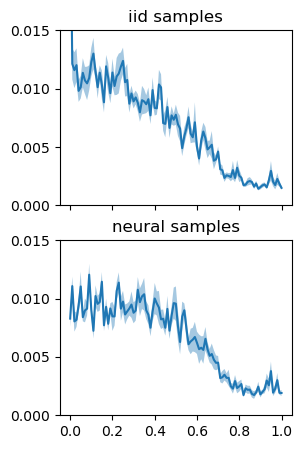

In [12]:
mean_entropy_iid = np.mean(entropies_iids, axis=0)
mean_entropy_seq = np.mean(entropies_seqs, axis=0)
std_entropy_iid = np.std(entropies_iids, axis=0) /  np.sqrt(num_runs)
std_entropy_seq = np.std(entropies_seqs, axis=0) / np.sqrt(num_runs)

fig, ax = plt.subplots(2, 1, figsize=(3, 5), sharex=True)
ls = np.linspace(0, 1, len(mean_entropy_seq))
ax[0].plot(ls, mean_entropy_iid)
ax[0].fill_between(ls, mean_entropy_iid-std_entropy_iid, mean_entropy_iid+std_entropy_iid, alpha=0.4)
ax[0].set(title='iid samples')
# ax[0].set(ylim=[0, 0.2])

ax[1].plot(ls, mean_entropy_seq)
ax[1].fill_between(ls, mean_entropy_seq-std_entropy_seq, mean_entropy_seq+std_entropy_seq, alpha=0.4)
# ax[1].set(title='neural samples', ylabel='KL divergence', xlabel='$\\beta_t$')
ax[1].set(title='neural samples')
# ax[1].set(ylim=[0, 0.2])

for a in ax:
    a.set(ylim=[0, 0.015], yticks=[0, 0.005, 0.01, 0.015], xticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

from plot import save_fig
save_fig(fig, 'figure2-evaluation-location-1e4-samples')